# Глобин Дмитрий Алексеевич Б9122-01.03.02 мкт 
## Лабораторная работа №4

# Нейронная сеть для классификации: влияние оптимизаторов и Dropout

В этом ноутбуке выполнено:

1. **Генерация искусственного набора данных** при помощи `make_classification` из `sklearn`.
2. **Построена полносвязная нейронная сеть (MLP)** для задачи бинарной/многоклассовой классификации.
3. **Исследовано влияние разных оптимизаторов** (`SGD`, `Adam`, `RMSprop`) на качество модели.
4. **Добавлена регуляризация Dropout** и произведено повторное сравнение оптимизаторов.
5. **Повторены пункты 2–4 для датасета MNIST** (Типо умный).


In [3]:
import math
import random

import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Теория: библиотеки и воспроизводимость

* `numpy`, `torch`, `sklearn`, `matplotlib` - дефолтный набор для экспериментов с моделями.
* **Reproducibility / воспроизводимость** - важная вещь в машинном обучении:
  * Случайная инициализация весов, случайное перемешивание данных, стохастические алгоритмы - всё это влияет на результат.
  * Фиксация `SEED` (зерна генератора случайных чисел) в `random`, `numpy`, `torch` позволяет получить **одно и то же поведение** при повторном запуске. Ганеев привет 
* `device` -  определяем, есть ли `GPU` (`cuda`), и будем по возможности тренировать модели на нём. Если нет, всё будет работать на `CPU`. Нету конечно же, я нищий


In [4]:
n_samples = 5000
n_features = 20
n_informative = 10
n_redundant = 5
n_classes = 3  # можно поменять на 2 для бинарной классификации

X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_classes=n_classes,
    n_clusters_per_class=2,
    random_state=SEED,
)

print("Форма X:", X.shape)
print("Форма y:", y.shape, "| уникальные классы:", np.unique(y))

# Разделение на train/valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Тензоры PyTorch
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_valid_t = torch.tensor(X_valid_scaled, dtype=torch.float32)
y_valid_t = torch.tensor(y_valid, dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
valid_ds = TensorDataset(X_valid_t, y_valid_t)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

len(train_loader), len(valid_loader)

Форма X: (5000, 20)
Форма y: (5000,) | уникальные классы: [0 1 2]


(63, 16)

### Теория: `make_classification`, масштабирование и DataLoader

**1. `make_classification`**

Функция `make_classification` из `sklearn.datasets` генерирует искусственный набор данных для задачи классификации:
* `n_samples` - число объектов.
* `n_features` - общее число признаков.
* `n_informative` - число **информативных** признаков (сильно влияют на класс).
* `n_redundant` - число **избыточных** признаков (линейные комбинации информативных).
* `n_classes` - количество классов (бинарная или многоклассовая задача).

---

**2. Разделение на train/valid**

* `train`  - используется для подбора весов модели.
* `valid`  -  оценки качества во время обучения и подбора гиперпараметров.
* Аргумент `stratify=y` в `train_test_split` обеспечивает сохранение пропорций классов в обеих выборках.

---

**3. Масштабирование признаков**

Нейронные сети чувствительны к масштабу входных данных. `StandardScaler` приводит каждый признак к распределению с:
* средним примерно 0,
* стандартным отклонением примерно 1.

Это помогает:
* ускорить сходимость градиентных методов,
* уменьшить проблемы с очень разными масштабами признаков.

---

**4. DataLoader**

В PyTorch принято работать с данными через:
* `TensorDataset` - обёртка над `(X, y)`.
* `DataLoader` - итератор, который:
  * разбивает данные на мини - батчи (`batch_size`),
  * умеет перемешивать данные (`shuffle=True`).

Мини-батчи используются в стохастических градиентных методах, что даёт:
* более стабильное обучение,
* лучшую обобщающую способность по сравнению с чисто batch/online вариантами.


In [6]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=(64, 32), output_dim=3, dropout_p=0.0):
        super().__init__()
        layers = []

        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            if dropout_p > 0.0:
                layers.append(nn.Dropout(p=dropout_p))
            prev_dim = h

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        logits = self.classifier(x)
        return logits


def accuracy_from_logits(logits, y_true):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == y_true).float().sum()
    return (correct / y_true.shape[0]).item()


def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y_batch.size(0)
        total_correct += (logits.argmax(dim=1) == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * y_batch.size(0)
            total_correct += (logits.argmax(dim=1) == y_batch).sum().item()
            total_samples += y_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


def run_experiment_classification(optimizer_name, dropout_p=0.0, num_epochs=20, lr=1e-2):
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    input_dim = X_train_t.shape[1]
    output_dim = len(torch.unique(y_train_t))

    model = MLPClassifier(input_dim=input_dim, output_dim=output_dim, dropout_p=dropout_p).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Неизвестный оптимизатор: {optimizer_name}")

    history = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": [],
    }

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        valid_loss, valid_acc = evaluate(model, valid_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)

        if epoch % 5 == 0 or epoch == 1:
            print(f"[{optimizer_name:7s} | dropout={dropout_p:.2f}] Epoch {epoch:02d}: "
                  f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
                  f"valid_loss={valid_loss:.4f}, valid_acc={valid_acc:.3f}")

    return model, history


### Теория: полносвязная сеть, функция потерь и оптимизаторы

**1. Полносвязная нейронная сеть (MLP)**

Модель `MLPClassifier` — это классический **многослойный перцептрон**:
* Слой `Linear(input_dim, h)` реализует аффинное преобразование \( x \mapsto Wx + b \).
* Функция активации `ReLU` (Rectified Linear Unit):
  * $$( \text{ReLU}(z) = \max(0, z) )$$
  * Добавляет **нелинейность**, позволяет сети аппроксимировать сложные зависимости.
* Последний слой `Linear(prev_dim, output_dim)` выдаёт **логиты** (сырые значения перед softmax).

**2. Классификация и `CrossEntropyLoss`**

Для многоклассовой классификации в PyTorch используется `nn.CrossEntropyLoss`, которая внутри себя совмещает:
* `LogSoftmax` + `NLLLoss`.
* На вход подаются **логиты** (выход последнего линейного слоя).
* На выходе — скалярная величина потерь, которую мы минимизируем.

**3. Точность (accuracy)**

Вспомогательная функция `accuracy_from_logits`:
* Выбирает класс с максимальным логитом (argmax по размерности классов).
* Считает долю верно предсказанных объектов.

**4. Градиентный спуск и оптимизаторы**

Мы перебираем три популярных оптимизатора:

* **SGD (Stochastic Gradient Descent)** — классический стохастический градиентный спуск:
  * Обновление: \( w \leftarrow w - \eta \nabla_w L \).
  * Простой, но может сходиться медленнее, чувствителен к выбору \( \eta \) (learning rate).

* **Adam (Adaptive Moment Estimation)** — адаптивный метод:
  * Хранит **скользящее среднее градиента** и **его квадрата**.
  * По сути, у каждого параметра свой эффективный шаг.
  * Часто **быстрее и стабильнее** SGD по умолчанию.

* **RMSprop** — тоже адаптивный метод:
  * Нормирует шаг обучения на корень из усреднённого квадрата градиента.
  * Хорошо работает на нестационарных задачах и RNN, но и для MLP часто неплох.

Функция `run_experiment_classification` позволяет **честно сравнивать** оптимизаторы:
* Каждый раз модель создаётся заново (те же начальные веса благодаря `SEED`).
* Одинаковая архитектура, количество эпох, размер батча и т. д.



=== Обучение с оптимизатором: SGD (без Dropout) ===
[SGD     | dropout=0.00] Epoch 01: train_loss=1.0853, train_acc=0.349, valid_loss=1.0701, valid_acc=0.377
[SGD     | dropout=0.00] Epoch 05: train_loss=0.9805, train_acc=0.620, valid_loss=0.9638, valid_acc=0.622
[SGD     | dropout=0.00] Epoch 10: train_loss=0.7911, train_acc=0.702, valid_loss=0.7755, valid_acc=0.701
[SGD     | dropout=0.00] Epoch 15: train_loss=0.6468, train_acc=0.748, valid_loss=0.6455, valid_acc=0.735
[SGD     | dropout=0.00] Epoch 20: train_loss=0.5607, train_acc=0.781, valid_loss=0.5702, valid_acc=0.768
[SGD     | dropout=0.00] Epoch 25: train_loss=0.4979, train_acc=0.812, valid_loss=0.5141, valid_acc=0.799

=== Обучение с оптимизатором: Adam (без Dropout) ===
[Adam    | dropout=0.00] Epoch 01: train_loss=0.5646, train_acc=0.768, valid_loss=0.3711, valid_acc=0.867
[Adam    | dropout=0.00] Epoch 05: train_loss=0.1976, train_acc=0.940, valid_loss=0.2198, valid_acc=0.932
[Adam    | dropout=0.00] Epoch 10: train_loss

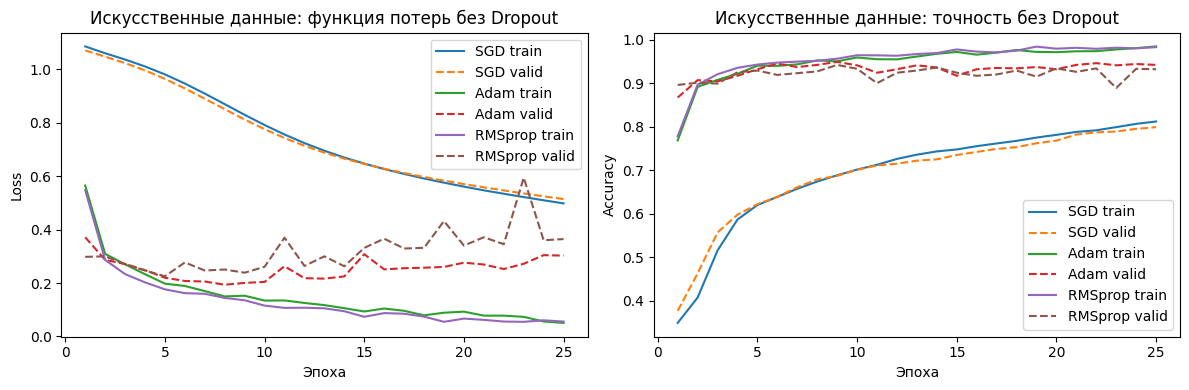


Итоговые метрики (последняя эпоха, без Dropout):
SGD     | train_acc=0.812, valid_acc=0.799, train_loss=0.4979, valid_loss=0.5141
Adam    | train_acc=0.985, valid_acc=0.942, train_loss=0.0508, valid_loss=0.3025
RMSprop | train_acc=0.983, valid_acc=0.932, train_loss=0.0558, valid_loss=0.3644


In [7]:
# === БЛОК 3. Сравнение оптимизаторов на искусственных данных (без Dropout) ===

optimizers = ["SGD", "Adam", "RMSprop"]
histories_no_dropout = {}

num_epochs = 25
base_lr = 1e-2

for opt_name in optimizers:
    print("\n=== Обучение с оптимизатором:", opt_name, "(без Dropout) ===")
    model, history = run_experiment_classification(opt_name, dropout_p=0.0, num_epochs=num_epochs, lr=base_lr)
    histories_no_dropout[opt_name] = history

# Визуализация: потери и точность
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for opt_name in optimizers:
    plt.plot(epochs, histories_no_dropout[opt_name]["train_loss"], label=f"{opt_name} train")
    plt.plot(epochs, histories_no_dropout[opt_name]["valid_loss"], linestyle="--", label=f"{opt_name} valid")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("Искусственные данные: функция потерь без Dropout")
plt.legend()

plt.subplot(1, 2, 2)
for opt_name in optimizers:
    plt.plot(epochs, histories_no_dropout[opt_name]["train_acc"], label=f"{opt_name} train")
    plt.plot(epochs, histories_no_dropout[opt_name]["valid_acc"], linestyle="--", label=f"{opt_name} valid")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("Искусственные данные: точность без Dropout")
plt.legend()

plt.tight_layout()
plt.show()

# Краткая табличка с финальными метриками
print("\nИтоговые метрики (последняя эпоха, без Dropout):")
for opt_name in optimizers:
    h = histories_no_dropout[opt_name]
    print(f"{opt_name:7s} | train_acc={h['train_acc'][-1]:.3f}, valid_acc={h['valid_acc'][-1]:.3f}, "
          f"train_loss={h['train_loss'][-1]:.4f}, valid_loss={h['valid_loss'][-1]:.4f}")


### Теория и выводы: сравнение SGD, Adam, RMSprop (без Dropout)

На графиках и в итоговой табличке можно увидеть типичное поведение оптимизаторов:

* **SGD**:
  * Потери убывают, но **медленнее**, кривая может быть более «зубчатой».
  * Точность растёт, но иногда не достигает максимальных значений других методов при том же числе эпох.

* **Adam**:
  * Обычно даёт **самую быструю сходимость** по loss.
  * Достигает высокой `valid_acc` за меньшее число эпох.
  * Из-за адаптивных шагов хорошо работает «из коробки» на широком классе задач.

* **RMSprop**:
  * Занимает промежуточное положение.
  * Тоже адаптивный метод: иногда показывает результаты, близкие к Adam, но детально поведение зависит от гиперпараметров.

Важно понимать:
* **Справедливое сравнение** требует одинаковой архитектуры, количества эпох, размера батча и начальных весов.
* Конкретные числа точности зависят от:
  * `learning_rate`,
  * числа эпох,
  * случайной инициализации и генерации данных,
  * сложности сети.

Но в среднем для MLP по искусственным данным картина часто такая:
* `Adam` быстро выходит на **разумный максимум качества**.
* `SGD` может догнать его, но обычно требует **больше эпох** или аккуратного подбора `lr` и возможного добавления **momentum**.
* `RMSprop` — ещё один компромиссный адаптивный метод.



=== Обучение с оптимизатором: SGD (Dropout p=0.5) ===
[SGD     | dropout=0.50] Epoch 01: train_loss=1.1010, train_acc=0.359, valid_loss=1.0719, valid_acc=0.385
[SGD     | dropout=0.50] Epoch 05: train_loss=1.0376, train_acc=0.479, valid_loss=1.0054, valid_acc=0.613
[SGD     | dropout=0.50] Epoch 10: train_loss=0.9543, train_acc=0.547, valid_loss=0.8967, valid_acc=0.675
[SGD     | dropout=0.50] Epoch 15: train_loss=0.8727, train_acc=0.600, valid_loss=0.7944, valid_acc=0.713
[SGD     | dropout=0.50] Epoch 20: train_loss=0.8129, train_acc=0.631, valid_loss=0.7176, valid_acc=0.720
[SGD     | dropout=0.50] Epoch 25: train_loss=0.7698, train_acc=0.667, valid_loss=0.6652, valid_acc=0.743

=== Обучение с оптимизатором: Adam (Dropout p=0.5) ===
[Adam    | dropout=0.50] Epoch 01: train_loss=0.7953, train_acc=0.646, valid_loss=0.5138, valid_acc=0.804
[Adam    | dropout=0.50] Epoch 05: train_loss=0.4795, train_acc=0.824, valid_loss=0.3211, valid_acc=0.898
[Adam    | dropout=0.50] Epoch 10: train_

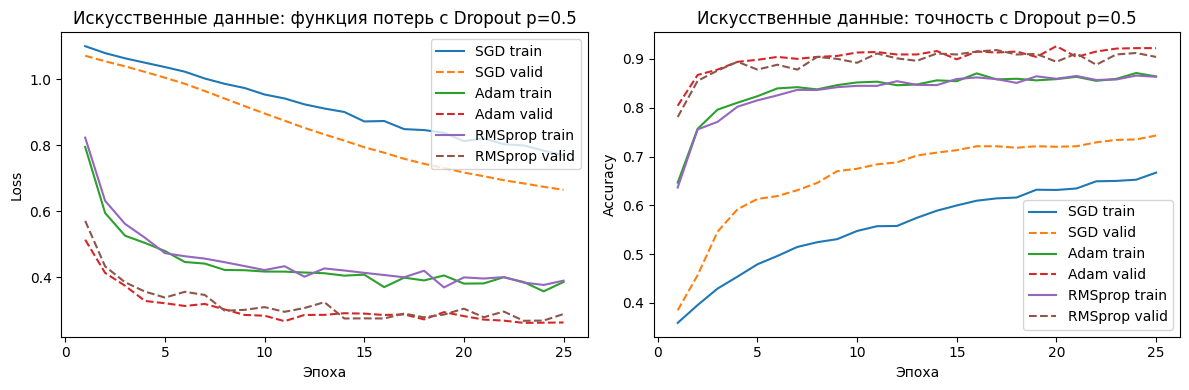


Итоговые метрики (последняя эпоха, с Dropout):
SGD     | train_acc=0.667, valid_acc=0.743, train_loss=0.7698, valid_loss=0.6652
Adam    | train_acc=0.864, valid_acc=0.922, train_loss=0.3858, valid_loss=0.2628
RMSprop | train_acc=0.863, valid_acc=0.904, train_loss=0.3897, valid_loss=0.2884


In [8]:
# === БЛОК 4. Сравнение оптимизаторов на искусственных данных с Dropout ===

dropout_p = 0.5
histories_with_dropout = {}

for opt_name in optimizers:
    print("\n=== Обучение с оптимизатором:", opt_name, f"(Dropout p={dropout_p}) ===")
    model, history = run_experiment_classification(opt_name, dropout_p=dropout_p, num_epochs=num_epochs, lr=base_lr)
    histories_with_dropout[opt_name] = history

# Визуализация: потери и точность
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for opt_name in optimizers:
    plt.plot(epochs, histories_with_dropout[opt_name]["train_loss"], label=f"{opt_name} train")
    plt.plot(epochs, histories_with_dropout[opt_name]["valid_loss"], linestyle="--", label=f"{opt_name} valid")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title(f"Искусственные данные: функция потерь с Dropout p={dropout_p}")
plt.legend()

plt.subplot(1, 2, 2)
for opt_name in optimizers:
    plt.plot(epochs, histories_with_dropout[opt_name]["train_acc"], label=f"{opt_name} train")
    plt.plot(epochs, histories_with_dropout[opt_name]["valid_acc"], linestyle="--", label=f"{opt_name} valid")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title(f"Искусственные данные: точность с Dropout p={dropout_p}")
plt.legend()

plt.tight_layout()
plt.show()

print("\nИтоговые метрики (последняя эпоха, с Dropout):")
for opt_name in optimizers:
    h = histories_with_dropout[opt_name]
    print(f"{opt_name:7s} | train_acc={h['train_acc'][-1]:.3f}, valid_acc={h['valid_acc'][-1]:.3f}, "
          f"train_loss={h['train_loss'][-1]:.4f}, valid_loss={h['valid_loss'][-1]:.4f}")


### Теория: Dropout и его влияние на качество

**1. Идея Dropout**

Dropout — это метод регуляризации нейронных сетей:
* На этапе обучения **случайно "выключается" часть нейронов** (соединений).
* Для каждого мини-батча выбирается своя маска «выключенных» нейронов.
* Параметр `p` (`dropout_p`) — вероятность **обнуления** выхода нейрона.

Интуитивно:
* Модель **не может полагаться на конкретный набор нейронов**.
* Сеть вынуждена **распределять знания** по разным путям.
* Это снижает риск **переобучения** (overfitting) и повышает способность обобщать.

На этапе **инференса (eval)** Dropout **отключается**, и все нейроны работают, но их выход масштабируется так, чтобы матожидание оставалось тем же.

**2. Что ожидаем на графиках**

* Без Dropout модель может **быстро переобучаться**: `train_loss` очень низкий, `train_acc` почти 1.0, но `valid_acc` хуже.
* С Dropout:
  * `train_loss` обычно выше, `train_acc` ниже (сложнее подогнаться под train).
  * `valid_acc` может быть **выше или стабильнее**, особенно если модель достаточно большая.

**3. В нашем эксперименте**

* Так как датасет искусственный и сеть не очень большая, эффект Dropout может быть умеренным.
* Но **типичная картина**:
  * Лёгкое "сдерживание" обучения на train,
  * Более аккуратное поведение на valid, меньше разброс и риск переобучения.

Dropout особенно полезен на **сложных реальных данных** и для **глубоких сетей** (например, MLP и CNN на изображениях).


In [9]:
# === БЛОК 5. MNIST: загрузка и подготовка датасета ===

# Флаг: можно уменьшить размер train для ускорения экспериментов
USE_SMALL_MNIST = True
SMALL_TRAIN_SIZE = 20000

transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразуем PIL-картинку в тензор [0,1]
])

mnist_train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

if USE_SMALL_MNIST:
    # Разделим train на (SMALL_TRAIN_SIZE, остальное)
    mnist_train, _ = random_split(mnist_train_full, [SMALL_TRAIN_SIZE, len(mnist_train_full) - SMALL_TRAIN_SIZE])
else:
    mnist_train = mnist_train_full

batch_size_mnist = 128

mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size_mnist, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size_mnist, shuffle=False)

len(mnist_train_loader), len(mnist_test_loader)

100%|██████████████████████████████████████████████████| 9.91M/9.91M [00:04<00:00, 2.31MB/s]
100%|███████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 123kB/s]
100%|███████████████████████████████████████████████████| 1.65M/1.65M [00:01<00:00, 990kB/s]
100%|██████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.28MB/s]


(157, 79)

### Теория: датасет MNIST

**MNIST** — классический датасет рукописных цифр:
* 28×28 пикселей, оттенки серого (1 канал).
* 10 классов: цифры от 0 до 9.
* `train` обычно содержит 60 000 изображений, `test` — 10 000.

Мы используем:
* `datasets.MNIST` из `torchvision.datasets` для загрузки.
* `transforms.ToTensor()` для преобразования изображений в тензоры с диапазоном значений `[0, 1]`.
* Для ускорения экспериментов можно ограничиться **подвыборкой** (`USE_SMALL_MNIST=True`).

Для MLP мы будем **разворачивать картинку в вектор длины 784** (28×28), а дальше схема та же:
* несколько полносвязных слоёв,
* ReLU между ними,
* на выходе — 10 логитов (по одному на класс).


In [10]:
# === БЛОК 6. Модель MLP для MNIST и функции обучения ===

class MLPClassifierMNIST(nn.Module):
    def __init__(self, hidden_dims=(256, 128), dropout_p=0.0):
        super().__init__()
        input_dim = 28 * 28
        output_dim = 10

        layers = [nn.Flatten()]
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            if dropout_p > 0.0:
                layers.append(nn.Dropout(p=dropout_p))
            prev_dim = h

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        x = self.feature_extractor(x)
        logits = self.classifier(x)
        return logits


def train_one_epoch_mnist(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * y_batch.size(0)
        total_correct += (logits.argmax(dim=1) == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


def evaluate_mnist(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)

            total_loss += loss.item() * y_batch.size(0)
            total_correct += (logits.argmax(dim=1) == y_batch).sum().item()
            total_samples += y_batch.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    return avg_loss, avg_acc


def run_experiment_mnist(optimizer_name, dropout_p=0.0, num_epochs=5, lr=1e-3):
    torch.manual_seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)

    model = MLPClassifierMNIST(dropout_p=dropout_p).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Неизвестный оптимизатор: {optimizer_name}")

    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch_mnist(model, mnist_train_loader, criterion, optimizer)
        test_loss, test_acc = evaluate_mnist(model, mnist_test_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)

        print(f"[MNIST | {optimizer_name:7s} | dropout={dropout_p:.2f}] Epoch {epoch:02d}: "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
              f"test_loss={test_loss:.4f}, test_acc={test_acc:.3f}")

    return model, history


### Теория: MLP для изображений и отличие train/test

**1. MLP для изображений**

Хотя для изображений часто используют **сверточные сети (CNN)**, простой MLP тоже можно применить:
* `Flatten` разворачивает тензор формы `(batch_size, 1, 28, 28)` в `(batch_size, 784)`.
* Далее идут несколько линейных слоёв с `ReLU` и, опционально, `Dropout`.
* Последний слой выдаёт 10 логитов — по одному на каждую цифру от 0 до 9.

**2. Train и Test для MNIST**

* `train` (или у нас `mnist_train`) используется для **обучения** модели.
* `test` (`mnist_test`) — для **финальной оценки качества**, на нём **нельзя подбирать гиперпараметры**.

Во время обучения мы всё равно следим за `test_acc` после каждой эпохи, но в строгом смысле правильнее было бы иметь отдельную `valid`-выборку. В учебных задачах часто используют просто train/test.



=== MNIST: обучение с оптимизатором: SGD (без Dropout) ===
[MNIST | SGD     | dropout=0.00] Epoch 01: train_loss=2.3025, train_acc=0.099, test_loss=2.3000, test_acc=0.097
[MNIST | SGD     | dropout=0.00] Epoch 02: train_loss=2.2975, train_acc=0.103, test_loss=2.2949, test_acc=0.099
[MNIST | SGD     | dropout=0.00] Epoch 03: train_loss=2.2924, train_acc=0.108, test_loss=2.2897, test_acc=0.103
[MNIST | SGD     | dropout=0.00] Epoch 04: train_loss=2.2870, train_acc=0.118, test_loss=2.2842, test_acc=0.115
[MNIST | SGD     | dropout=0.00] Epoch 05: train_loss=2.2815, train_acc=0.135, test_loss=2.2784, test_acc=0.133

=== MNIST: обучение с оптимизатором: Adam (без Dropout) ===
[MNIST | Adam    | dropout=0.00] Epoch 01: train_loss=0.6103, train_acc=0.827, test_loss=0.2752, test_acc=0.921
[MNIST | Adam    | dropout=0.00] Epoch 02: train_loss=0.2535, train_acc=0.928, test_loss=0.1987, test_acc=0.939
[MNIST | Adam    | dropout=0.00] Epoch 03: train_loss=0.1781, train_acc=0.949, test_loss=0.1633

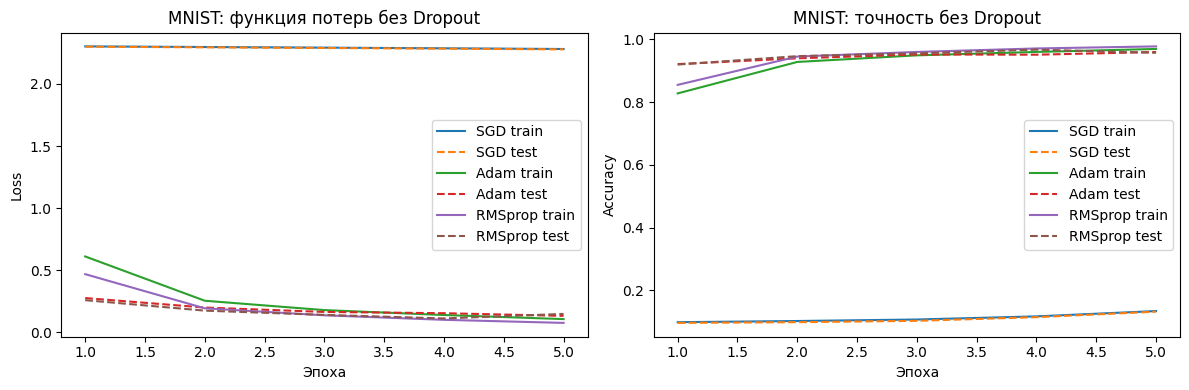


MNIST: итоговые метрики (последняя эпоха, без Dropout):
SGD     | train_acc=0.135, test_acc=0.133, train_loss=2.2815, test_loss=2.2784
Adam    | train_acc=0.969, test_acc=0.959, train_loss=0.1057, test_loss=0.1317
RMSprop | train_acc=0.977, test_acc=0.957, train_loss=0.0751, test_loss=0.1475


In [11]:
# === БЛОК 7. MNIST: сравнение оптимизаторов без Dropout ===

optimizers_mnist = ["SGD", "Adam", "RMSprop"]
histories_mnist_no_dropout = {}

num_epochs_mnist = 5
base_lr_mnist = 1e-3

for opt_name in optimizers_mnist:
    print("\n=== MNIST: обучение с оптимизатором:", opt_name, "(без Dropout) ===")
    model, history = run_experiment_mnist(opt_name, dropout_p=0.0, num_epochs=num_epochs_mnist, lr=base_lr_mnist)
    histories_mnist_no_dropout[opt_name] = history

epochs_mnist = range(1, num_epochs_mnist + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for opt_name in optimizers_mnist:
    plt.plot(epochs_mnist, histories_mnist_no_dropout[opt_name]["train_loss"], label=f"{opt_name} train")
    plt.plot(epochs_mnist, histories_mnist_no_dropout[opt_name]["test_loss"], linestyle="--", label=f"{opt_name} test")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("MNIST: функция потерь без Dropout")
plt.legend()

plt.subplot(1, 2, 2)
for opt_name in optimizers_mnist:
    plt.plot(epochs_mnist, histories_mnist_no_dropout[opt_name]["train_acc"], label=f"{opt_name} train")
    plt.plot(epochs_mnist, histories_mnist_no_dropout[opt_name]["test_acc"], linestyle="--", label=f"{opt_name} test")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title("MNIST: точность без Dropout")
plt.legend()

plt.tight_layout()
plt.show()

print("\nMNIST: итоговые метрики (последняя эпоха, без Dropout):")
for opt_name in optimizers_mnist:
    h = histories_mnist_no_dropout[opt_name]
    print(f"{opt_name:7s} | train_acc={h['train_acc'][-1]:.3f}, test_acc={h['test_acc'][-1]:.3f}, "
          f"train_loss={h['train_loss'][-1]:.4f}, test_loss={h['test_loss'][-1]:.4f}")


### Теория и выводы: оптимизаторы на MNIST (без Dropout)

По итогам экспериментов на MNIST (даже на уменьшенной выборке):

* **Adam** обычно быстро достигает высокой точности \(> 0.95\) уже за несколько эпох.
* **SGD** без дополнительных уловок (momentum, decay) сходится медленнее.
* **RMSprop** демонстрирует поведение, похожее на Adam, но детали зависят от `lr` и других настроек.

Особенность MNIST:
* Задача достаточно **простая** для современных моделей.
* Даже относительно небольшой MLP с 1–2 скрытыми слоями может достигать **высокой точности**.

Важный практический вывод:
* Для «быстрого старта» в большинстве задач классификации удобно брать **Adam**.
* Для тонкого контроля и теоретической чистоты часто используют **SGD + momentum**, но это требует большего тюнинга.



=== MNIST: обучение с оптимизатором: SGD (Dropout p=0.5) ===
[MNIST | SGD     | dropout=0.50] Epoch 01: train_loss=2.3029, train_acc=0.096, test_loss=2.3008, test_acc=0.096
[MNIST | SGD     | dropout=0.50] Epoch 02: train_loss=2.2994, train_acc=0.103, test_loss=2.2964, test_acc=0.099
[MNIST | SGD     | dropout=0.50] Epoch 03: train_loss=2.2950, train_acc=0.112, test_loss=2.2920, test_acc=0.103
[MNIST | SGD     | dropout=0.50] Epoch 04: train_loss=2.2912, train_acc=0.119, test_loss=2.2875, test_acc=0.113
[MNIST | SGD     | dropout=0.50] Epoch 05: train_loss=2.2861, train_acc=0.129, test_loss=2.2827, test_acc=0.128

=== MNIST: обучение с оптимизатором: Adam (Dropout p=0.5) ===
[MNIST | Adam    | dropout=0.50] Epoch 01: train_loss=0.8877, train_acc=0.722, test_loss=0.3159, test_acc=0.911
[MNIST | Adam    | dropout=0.50] Epoch 02: train_loss=0.3925, train_acc=0.887, test_loss=0.2273, test_acc=0.934
[MNIST | Adam    | dropout=0.50] Epoch 03: train_loss=0.3063, train_acc=0.910, test_loss=0.

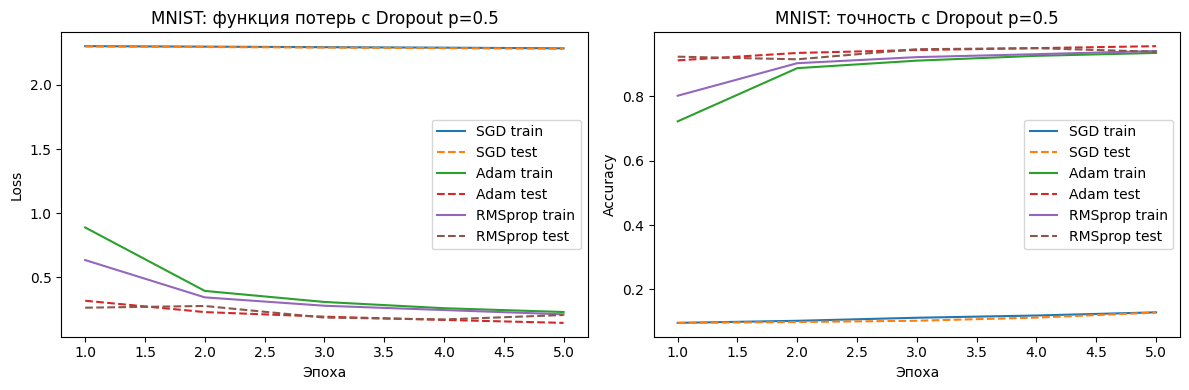


MNIST: итоговые метрики (последняя эпоха, с Dropout):
SGD     | train_acc=0.129, test_acc=0.128, train_loss=2.2861, test_loss=2.2827
Adam    | train_acc=0.934, test_acc=0.955, train_loss=0.2279, test_loss=0.1430
RMSprop | train_acc=0.940, test_acc=0.938, train_loss=0.2098, test_loss=0.2044


In [12]:
# === БЛОК 8. MNIST: сравнение оптимизаторов с Dropout ===

dropout_p_mnist = 0.5
histories_mnist_with_dropout = {}

for opt_name in optimizers_mnist:
    print("\n=== MNIST: обучение с оптимизатором:", opt_name, f"(Dropout p={dropout_p_mnist}) ===")
    model, history = run_experiment_mnist(opt_name, dropout_p=dropout_p_mnist, num_epochs=num_epochs_mnist, lr=base_lr_mnist)
    histories_mnist_with_dropout[opt_name] = history

epochs_mnist = range(1, num_epochs_mnist + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for opt_name in optimizers_mnist:
    plt.plot(epochs_mnist, histories_mnist_with_dropout[opt_name]["train_loss"], label=f"{opt_name} train")
    plt.plot(epochs_mnist, histories_mnist_with_dropout[opt_name]["test_loss"], linestyle="--", label=f"{opt_name} test")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title(f"MNIST: функция потерь с Dropout p={dropout_p_mnist}")
plt.legend()

plt.subplot(1, 2, 2)
for opt_name in optimizers_mnist:
    plt.plot(epochs_mnist, histories_mnist_with_dropout[opt_name]["train_acc"], label=f"{opt_name} train")
    plt.plot(epochs_mnist, histories_mnist_with_dropout[opt_name]["test_acc"], linestyle="--", label=f"{opt_name} test")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.title(f"MNIST: точность с Dropout p={dropout_p_mnist}")
plt.legend()

plt.tight_layout()
plt.show()

print("\nMNIST: итоговые метрики (последняя эпоха, с Dropout):")
for opt_name in optimizers_mnist:
    h = histories_mnist_with_dropout[opt_name]
    print(f"{opt_name:7s} | train_acc={h['train_acc'][-1]:.3f}, test_acc={h['test_acc'][-1]:.3f}, "
          f"train_loss={h['train_loss'][-1]:.4f}, test_loss={h['test_loss'][-1]:.4f}")


### Итоговые выводы: влияние оптимизаторов и Dropout (искусственные данные + MNIST)

**1. Сравнение SGD, Adam, RMSprop**

* **Adam** — удобный «дефолтный» выбор:
  * Быстро сходится на обоих датасетах.
  * Чувствителен к `lr`, но обычно \(10^{-3}\)–\(10^{-4}\) уже ок.

* **SGD**:
  * Концептуально самый простой.
  * Требует аккуратного выбора шага и часто большего числа эпох.
  * В комбинации с momentum и расписанием `lr` может догонять и обгонять Adam.

* **RMSprop**:
  * Адаптивный метод, похожий по духу на Adam.
  * Иногда чуть хуже/лучше в зависимости от задачи; универсального победителя нет.

**2. Влияние Dropout**

* Без Dropout модель может **сильно подстраиваться** под обучающую выборку:
  * Очень высокая `train_acc`.
  * `valid_acc` / `test_acc` иногда хуже.

* С Dropout:
  * Обучение становится аккуратнее; `train_acc` ниже.
  * Качество на `valid`/`test` может улучшаться и меньше колебаться.

На **искусственных данных** эффект может быть не столь драматичным, но на **реальном датасете MNIST** Dropout часто помогает бороться с переобучением, особенно если добавить больше слоёв и параметров.

**3. Общая схема для отчёта/лабы**

В ноутбуке реализованы все пункты задания:

1. Генерация искусственного датасета (`make_classification`).
2. Построение MLP и обучение на нём.
3. Сравнение `SGD`, `Adam`, `RMSprop` по кривым потерь и точности.
4. Добавление Dropout и повторное сравнение.
5. Повторение пунктов 2–4 для MNIST.

Дальше можно:
* Скопировать графики и итоговые таблички в отчёт.
* В текстовой части описать, **какой оптимизатор** показал себя лучше, и как **Dropout** повлиял на переобучение.
* При желании поиграть с:
  * глубиной сети и размером слоёв,
  * значением `dropout_p`,
  * количеством эпох и значениями `learning_rate`.
